# 1. Import packages and Global parameters setting

In [1]:
import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

ITERATIONS = 10
CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

In [2]:
import cvxpy as cp
import numpy as np
import time

x1 = cp.Variable(1)
x2 = cp.Variable(1)
x3 = cp.Variable(1)

objective = 10 * (x1 + x2)**2 + (x1 - 2)**2 + 20 * cp.abs(x3 - 3) + cp.exp(x3)
g = (x1 + 3)**2 + x2 - 36
h = 2*x1 + 3*x2 + 5*x3 - 7
problem = cp.Problem(cp.Minimize(objective), [g <= 0.0, h == 0.0])
t0 = time.time()
problem.solve(solver='SCS')
print('time: ' + str(time.time()-t0))
print(problem.value)
print(x1.value, x2.value, x3.value)

time: 0.021512269973754883
27.12743167761873
[3.08598977] [-3.41178669] [2.21267611]


# 2. The 5th NCP

In [3]:
# Qin, 2014 TNNLS, example 1
nx = 3
nu = 1
NY = nx+nu

xu0 = jnp.array([0, 0, 0, 0])
A = jnp.array([[2., 3., 5.]])
b = jnp.array([7.])
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    x1, x2, x3 = x[0], x[1], x[2]

    output = 10 * (x1 + x2)**2 + (x1 - 2)**2 + 20 * jnp.abs(x3 - 3) + jnp.exp(x3)
    return output

def g(x):
    x1, x2, x3 = x[0], x[1], x[2]
    g1 = (x1 + 3)**2 + x2 - 36
    output = jnp.array([g1])
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

In [4]:
def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, \
        f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0).all():
        obj = f(x)
    else:
        obj = np.inf
    return obj

sol = solve_ivp(ODE, [0., 10.], xu0, t_eval=np.arange(0, 10, 0.01), method='BDF')
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)

27.127434
[ 3.08601308 -3.41181183  2.21268177  0.        ]


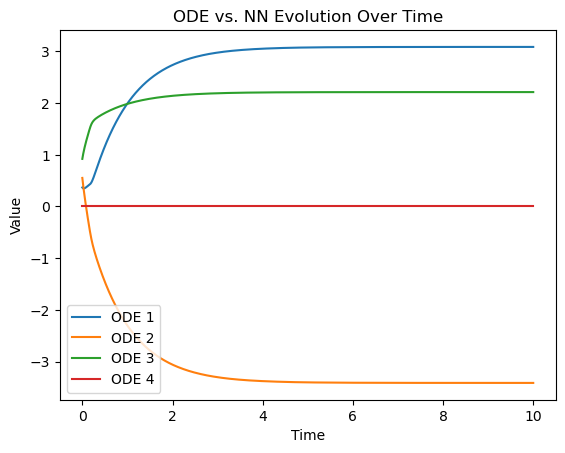

In [5]:
import matplotlib.pyplot as plt
y_ODE = sol.y
t_eval = np.linspace(0., 10., 1000)
# Create a figure and axes
fig, ax = plt.subplots()

p_values = np.empty_like(y_ODE) 
for i in range(y_ODE.shape[1]):
    p = P(y_ODE[:, i])
    p_values[:, i] = p

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, p_values[i], label=f'ODE {i+1}')  # Adjust label as needed

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()

In [6]:
x, u = result[:nx], result[nx:]
error1 = df(x)+u@dg(x)
error1 = np.max(np.abs((error1)))
error2 = u-np.clip(u+g(x),a_min=0,a_max=None)
error2 = np.max(np.abs((error2)))
print(error1, error2)

10.859804 0.0


# 3. The method

In [7]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.linear2 = nn.Linear(100, NY)

    def forward(self, x):
        t = x
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x

class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE)
        self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if CUDA:
            net = net.cuda()

        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        L_y_iterations = []
        L_net = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()

            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

            # Monitor
            if i%10==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                L_net.append(deepcopy(net))
                print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
            i = i+1
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        dy = self.vODE(t.cpu().detach().numpy(), y[:, :].cpu().detach().numpy())
        dy = np.array(dy)
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [8]:
LR = 0.01
NBATCH = 128 # 512
ITERATIONS = 20

In [9]:
y0 = np.array([0., 0., 0., 0.])
example_1 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1.NN_method() # train
res_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

T: 10, y_T_ODE: [ 3.0851 -3.4124  2.2134  0.    ], epsilon_ODE: 27.1275,  Iteration: 0, Loss: 35.7267,  epsilon_best: 41.1729, y_T: [ 0.3633 -0.0757  1.3001  0.0231], ||y_T_ODE-y_T_best||_2: 4.4019
T: 10, y_T_ODE: [ 3.0851 -3.4124  2.2134  0.    ], epsilon_ODE: 27.1275,  Iteration: 10, Loss: 562.6481,  epsilon_best: 27.1573, y_T: [ 2.9287 -3.2513  2.1793  0.549 ], ||y_T_ODE-y_T_best||_2: 0.5941


In [10]:
y0 = np.array([1., 0., -2., 3.])
example_2 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_2.NN_method() # train
res_2 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

T: 10, y_T_ODE: [ 3.0845 -3.4128  2.2139  0.0202], epsilon_ODE: 27.1275,  Iteration: 0, Loss: 235.2544,  epsilon_best: 137.8620, y_T: [2.0853 0.7302 0.1277 2.6882], ||y_T_ODE-y_T_best||_2: 5.4437
T: 10, y_T_ODE: [ 3.0845 -3.4128  2.2139  0.0202], epsilon_ODE: 27.1275,  Iteration: 10, Loss: 282.1833,  epsilon_best: 31.4955, y_T: [ 1.2595 -1.4376  1.7588  0.    ], ||y_T_ODE-y_T_best||_2: 2.7276


In [11]:
y0 = np.array([-1., 1., -1., 1.])
example_3 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_3.NN_method() # train
res_3 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

T: 10, y_T_ODE: [ 3.0846 -3.4128  2.2138  0.0067], epsilon_ODE: 27.1275,  Iteration: 0, Loss: 21.6177,  epsilon_best: 63.0543, y_T: [-0.3744  1.3696  0.728   1.5507], ||y_T_ODE-y_T_best||_2: 6.2791
T: 10, y_T_ODE: [ 3.0846 -3.4128  2.2138  0.0067], epsilon_ODE: 27.1275,  Iteration: 10, Loss: 724.7543,  epsilon_best: 29.7049, y_T: [ 1.5949 -1.9322  1.9213  0.    ], ||y_T_ODE-y_T_best||_2: 2.1206


In [12]:
print(f"IP: {res_1['IP']}, OuC at last iteration: {res_1['L_epsilon'][-1]:.4f}")
print(f"IP: {res_2['IP']}, OuC at last iteration: {res_2['L_epsilon'][-1]:.4f}")
print(f"IP: {res_3['IP']}, OuC at last iteration: {res_3['L_epsilon'][-1]:.4f}")

IP: [0. 0. 0. 0.], OuC at last iteration: 27.1573
IP: [ 1.  0. -2.  3.], OuC at last iteration: 31.4955
IP: [-1.  1. -1.  1.], OuC at last iteration: 29.5415


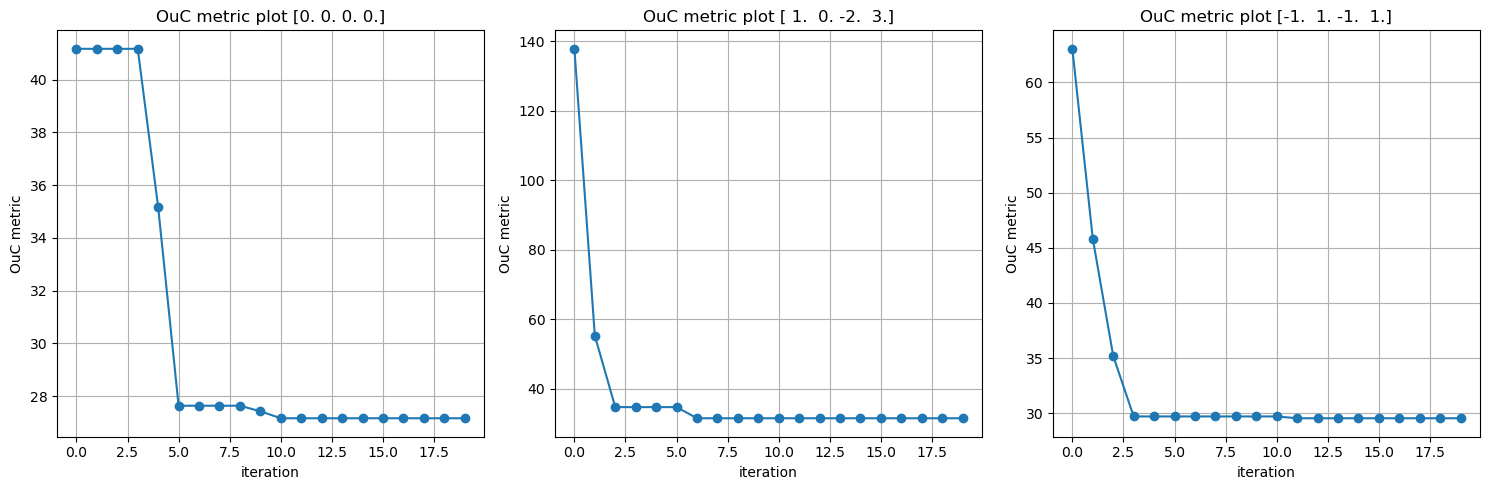

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot data for each subplot
axes[0].plot(res_1['L_epsilon'], marker='o', linestyle='-')
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('OuC metric')
axes[0].set_title(f'OuC metric plot {res_1["IP"]}')
axes[0].grid(True)

axes[1].plot(res_2['L_epsilon'], marker='o', linestyle='-')
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('OuC metric')
axes[1].set_title(f'OuC metric plot {res_2["IP"]}')
axes[1].grid(True)

axes[2].plot(res_3['L_epsilon'], marker='o', linestyle='-')
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('OuC metric')
axes[2].set_title(f'OuC metric plot {res_3["IP"]}')
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 100)

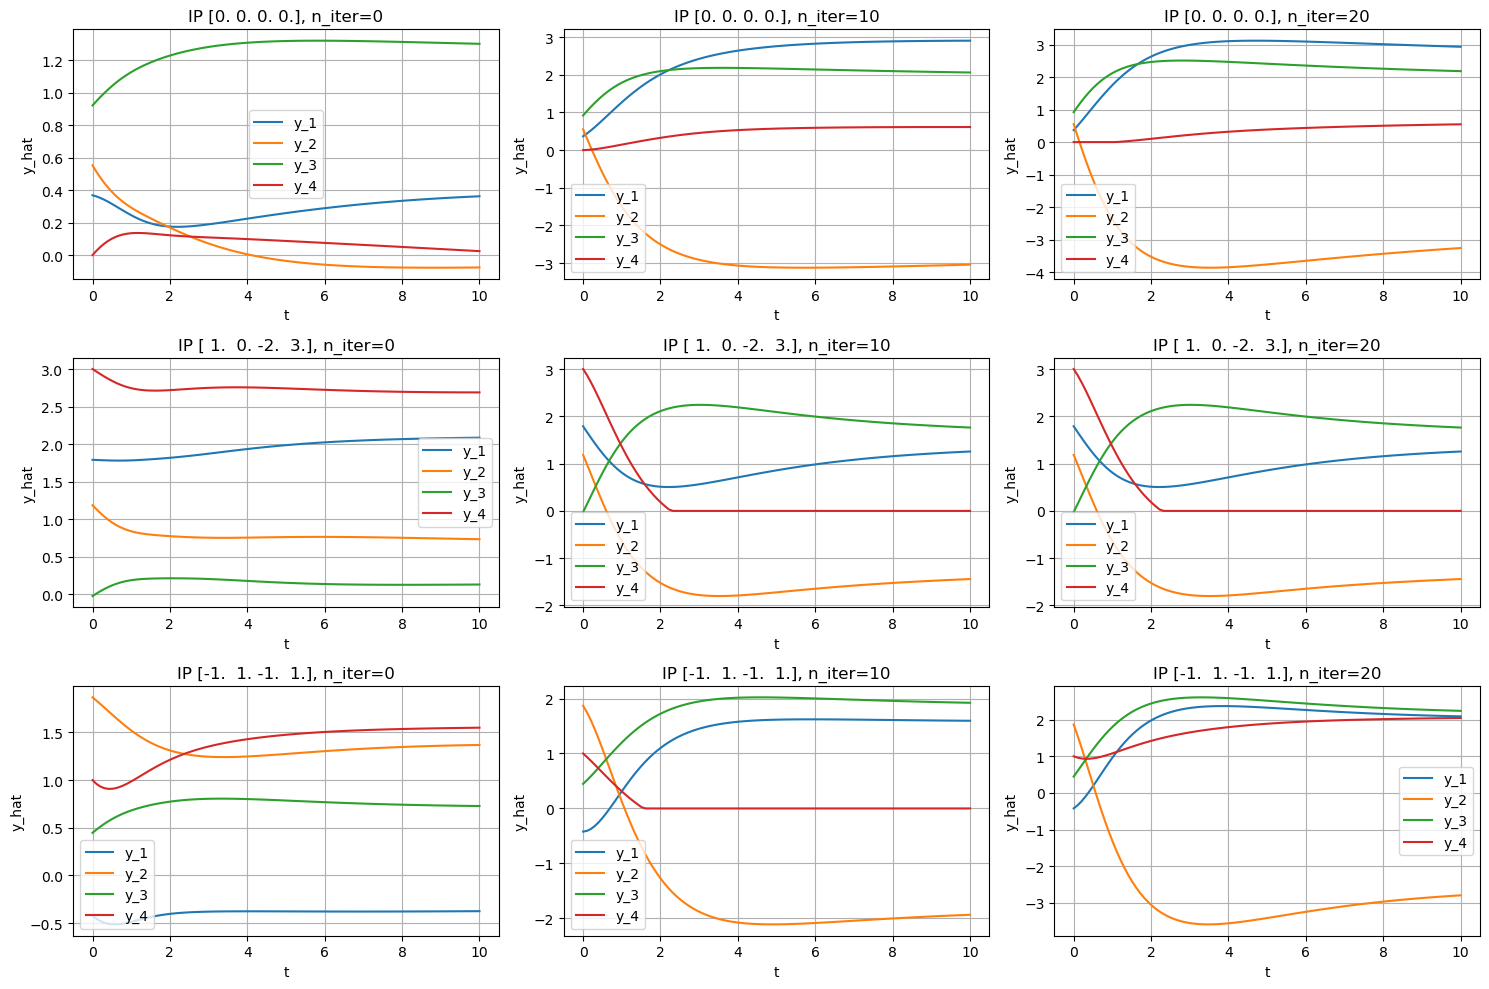

In [15]:


# Create a figure and axes for 9 subplots (3 rows, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust figsize as needed

# Define the n_iter values to plot
n_iters = [0, 10, 20]

# Plot data for each subplot
for i, res in enumerate([res_1, res_2, res_3]):
    for j, n_iter in enumerate(n_iters):
        row = i 
        col = j

        y_proj = res['L_y_iterations'][n_iter].T

        # Iterate and plot
        for k in range(y_ODE.shape[0]):
            axes[row, col].plot(t_eval, y_proj[k], label=f'y_{k+1}', linestyle='-')

        axes[row, col].set_xlabel('t')
        axes[row, col].set_ylabel('y_hat')
        axes[row, col].set_title(f'IP {res['IP']}, n_iter={n_iter}')
        axes[row, col].legend()
        axes[row, col].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [16]:
LR = 0.01
NBATCH = 512 # 512
ITERATIONS = 20

In [17]:
y0 = np.array([0., 0., 0., 0.])
example_1 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_1.NN_method() # train
res_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

T: 10, y_T_ODE: [ 3.0851 -3.4124  2.2134  0.    ], epsilon_ODE: 27.1275,  Iteration: 0, Loss: 17.2940,  epsilon_best: 47.2084, y_T: [0.3689 0.2391 1.109  0.    ], ||y_T_ODE-y_T_best||_2: 4.6830
T: 10, y_T_ODE: [ 3.0851 -3.4124  2.2134  0.    ], epsilon_ODE: 27.1275,  Iteration: 10, Loss: 1282.3079,  epsilon_best: 28.8478, y_T: [ 3.1398 -3.8446  2.4508  0.1822], ||y_T_ODE-y_T_best||_2: 0.5285


In [18]:
y0 = np.array([1., 0., -2., 3.])
example_2 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_2.NN_method() # train
res_2 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

T: 10, y_T_ODE: [ 3.0845 -3.4128  2.2139  0.0202], epsilon_ODE: 27.1275,  Iteration: 0, Loss: 249.0686,  epsilon_best: 218.8540, y_T: [ 2.5908  1.2791 -0.4038  2.8254], ||y_T_ODE-y_T_best||_2: 6.0811
T: 10, y_T_ODE: [ 3.0845 -3.4128  2.2139  0.0202], epsilon_ODE: 27.1275,  Iteration: 10, Loss: 64.3542,  epsilon_best: 31.3718, y_T: [ 1.2911 -1.4669  1.7637  0.    ], ||y_T_ODE-y_T_best||_2: 2.6845


In [19]:
y0 = np.array([-1., 1., -1., 1.])
example_3 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_3.NN_method() # train
res_3 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_y_iterations': L_y_iterations,
    'L_loss': L_loss,
    'IP': y0
}

T: 10, y_T_ODE: [ 3.0846 -3.4128  2.2138  0.0067], epsilon_ODE: 27.1275,  Iteration: 0, Loss: 20.1942,  epsilon_best: 66.7112, y_T: [-0.677   1.7057  0.6474  1.4954], ||y_T_ODE-y_T_best||_2: 6.7096
T: 10, y_T_ODE: [ 3.0846 -3.4128  2.2138  0.0067], epsilon_ODE: 27.1275,  Iteration: 10, Loss: 1251.0181,  epsilon_best: 27.6038, y_T: [ 2.9532 -3.4828  2.3084  0.    ], ||y_T_ODE-y_T_best||_2: 0.1766


In [20]:
print(f"IP: {res_1['IP']}, OuC at last iteration: {res_1['L_epsilon'][-1]:.4f}")
print(f"IP: {res_2['IP']}, OuC at last iteration: {res_2['L_epsilon'][-1]:.4f}")
print(f"IP: {res_3['IP']}, OuC at last iteration: {res_3['L_epsilon'][-1]:.4f}")

IP: [0. 0. 0. 0.], OuC at last iteration: 27.7545
IP: [ 1.  0. -2.  3.], OuC at last iteration: 31.3718
IP: [-1.  1. -1.  1.], OuC at last iteration: 27.6038


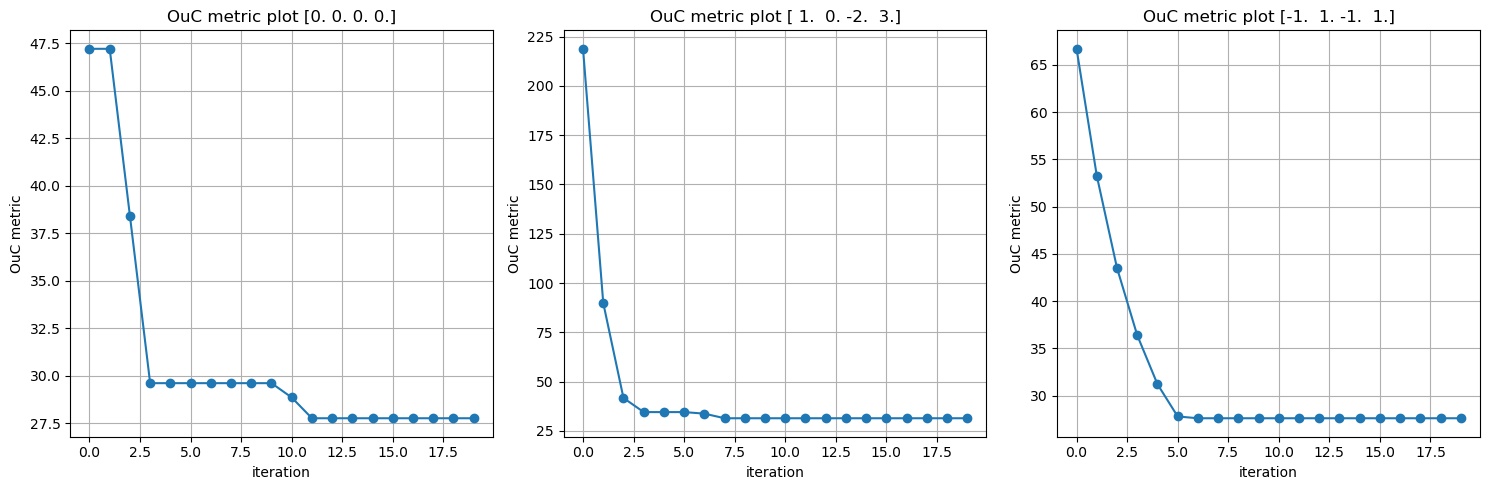

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot data for each subplot
axes[0].plot(res_1['L_epsilon'], marker='o', linestyle='-')
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('OuC metric')
axes[0].set_title(f'OuC metric plot {res_1["IP"]}')
axes[0].grid(True)

axes[1].plot(res_2['L_epsilon'], marker='o', linestyle='-')
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('OuC metric')
axes[1].set_title(f'OuC metric plot {res_2["IP"]}')
axes[1].grid(True)

axes[2].plot(res_3['L_epsilon'], marker='o', linestyle='-')
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('OuC metric')
axes[2].set_title(f'OuC metric plot {res_3["IP"]}')
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

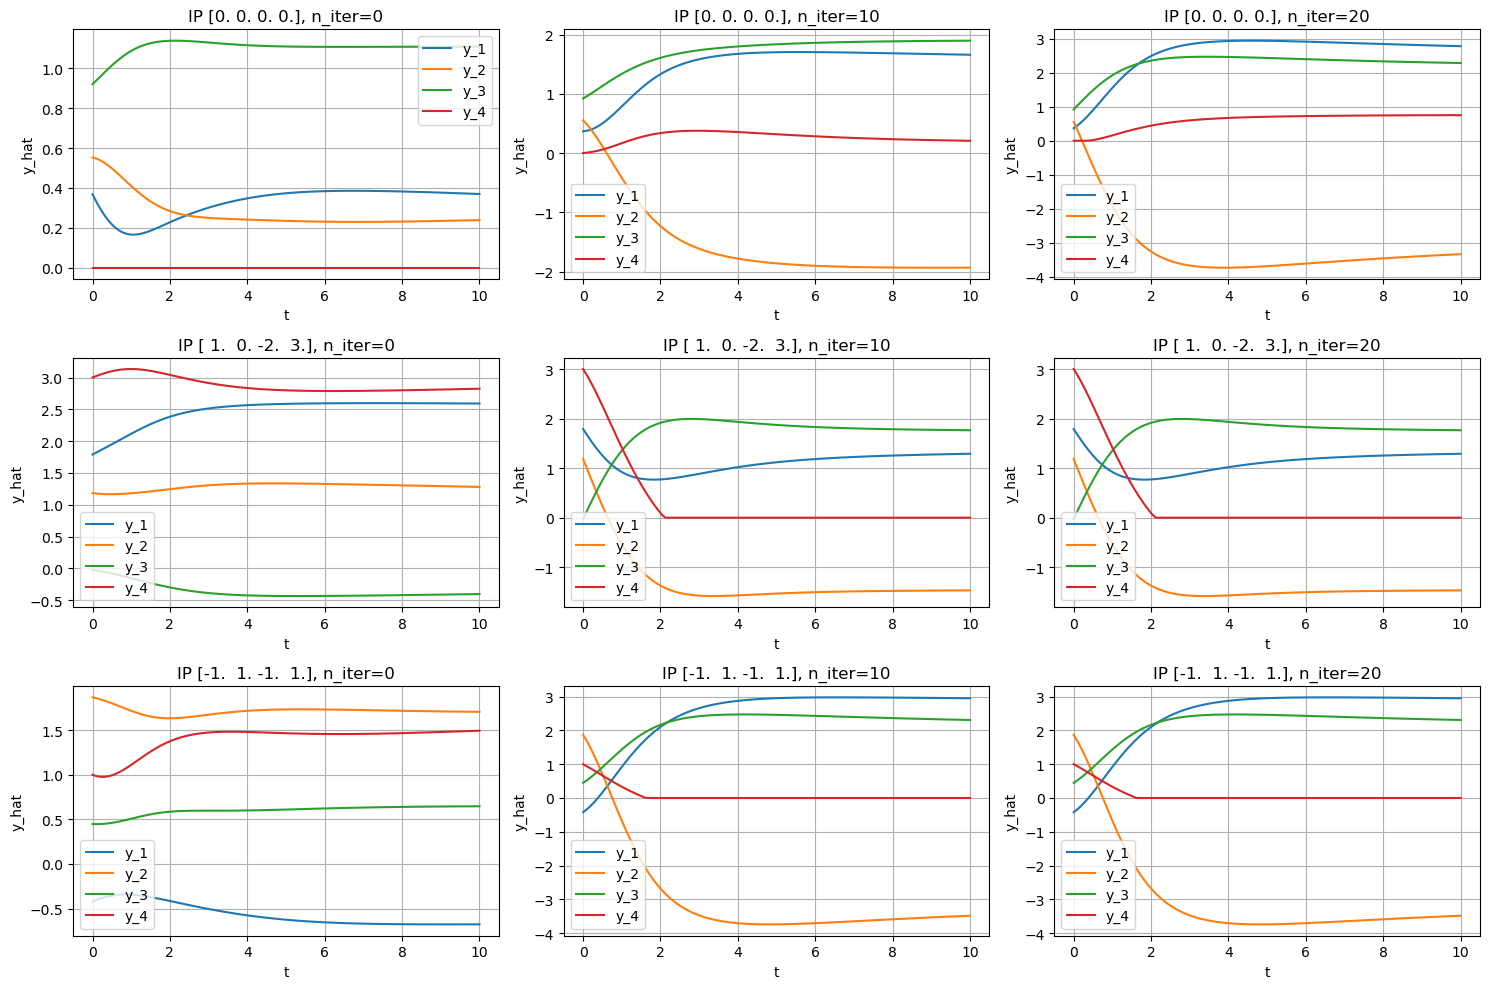

In [22]:


# Create a figure and axes for 9 subplots (3 rows, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust figsize as needed

# Define the n_iter values to plot
n_iters = [0, 10, 20]

# Plot data for each subplot
for i, res in enumerate([res_1, res_2, res_3]):
    for j, n_iter in enumerate(n_iters):
        row = i 
        col = j

        y_proj = res['L_y_iterations'][n_iter].T

        # Iterate and plot
        for k in range(y_ODE.shape[0]):
            axes[row, col].plot(t_eval, y_proj[k], label=f'y_{k+1}', linestyle='-')  # Adjust label and style

        axes[row, col].set_xlabel('t')
        axes[row, col].set_ylabel('y_hat')
        axes[row, col].set_title(f'IP {res['IP']}, n_iter={n_iter}')
        axes[row, col].legend()
        axes[row, col].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

Check ODE evolution

In [33]:

sol = solve_ivp(ODE, [0, 10], y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y

In [34]:
t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net_best(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

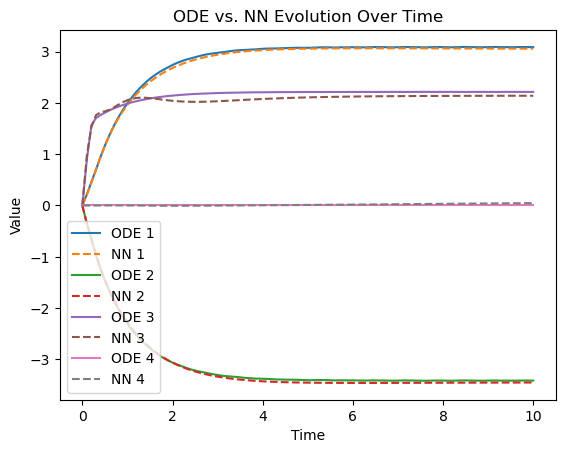

In [35]:
# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()